In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from preprocess import load_images
from scipy.signal import medfilt2d

In [2]:
x, y = load_images("DMED")

'load_images'  8015.91 ms


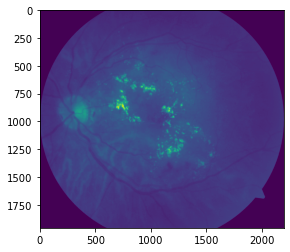

In [3]:
hsv = cv2.cvtColor(x[0], cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)
plt.imshow(v)

In [4]:
import numpy as np
from scipy import ndimage
import sys
import skimage as sk
import cv2
from scipy.ndimage import median_filter
from skimage import measure
from skimage.morphology import reconstruction
from skimage.filters import threshold_otsu
import time

In [5]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

In [6]:
@timeit
def get_median_filt(img, newSize):
    #return np.double(median_filter(img, (round(newSize[0]/30), round(newSize[1]/30))))
    return np.double(medfilt2d(img, (round(newSize[0]/30), round(newSize[0]/30))))

@timeit
def get_reconstructed_bkg(img, medBg):
    maskImg = img
    pxLbl = maskImg < medBg
    maskImg[pxLbl] = medBg[pxLbl]
    return reconstruction(medBg.astype('uint8'), maskImg.astype('uint8'), method='dilation')

@timeit
def get_subtracted_img(img, medBg, imgFovMask):
    medRestored =  get_reconstructed_bkg(np.double(img), medBg)
    plot_it(medRestored, 'medRestored')
    subImg = np.double(img) - medRestored
    plot_it(subImg, 'imgV8 - medRestored') # TAMAM
    subImg = subImg * np.double(imgFovMask)
    plot_it(subImg, 'subimg * fovMask') # TAMAM
    subImg[subImg > 0] = 0
    plot_it(subImg, 'subimg[subimg<0] = 0') # GHALAT!
    return np.array(subImg < 0, dtype=np.uint8)


In [7]:
@timeit
def kirschEdges(gray):
    if gray.ndim > 2:
        raise Exception("Image should be grayscale.")
    kernelG1 = np.array([[5, 5, 5],
                         [-3, 0, -3],
                         [-3, -3, -3]], dtype=np.float32) / 15
    kernelG2 = np.array([[5, 5, -3],
                         [5, 0, -3],
                         [-3, -3, -3]], dtype=np.float32) / 15
    kernelG3 = np.array([[5, -3, -3],
                         [5, 0, -3],
                         [5, -3, -3]], dtype=np.float32) / 15
    kernelG4 = np.array([[-3, -3, -3],
                         [5, 0, -3],
                         [5, 5, -3]], dtype=np.float32) / 15
    kernelG5 = np.array([[-3, -3, -3],
                         [-3, 0, -3],
                         [5, 5, 5]], dtype=np.float32) / 15
    kernelG6 = np.array([[-3, -3, -3],
                         [-3, 0, 5],
                         [-3, 5, 5]], dtype=np.float32) / 15
    kernelG7 = np.array([[-3, -3, 5],
                         [-3, 0, 5],
                         [-3, -3, 5]], dtype=np.float32) / 15
    kernelG8 = np.array([[-3, 5, 5],
                         [-3, 0, 5],
                         [-3, -3, -3]], dtype=np.float32) / 15
    #g1 = cv2.normalize(cv2.filter2D(gray, cv2.CV_64F, kernelG1), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    g1 = cv2.filter2D(gray, cv2.CV_64F, kernelG1)
    g2 = cv2.filter2D(gray, cv2.CV_64F, kernelG2)
    g3 = cv2.filter2D(gray, cv2.CV_64F, kernelG3)
    g4 = cv2.filter2D(gray, cv2.CV_64F, kernelG4)
    g5 = cv2.filter2D(gray, cv2.CV_64F, kernelG5)
    g6 = cv2.filter2D(gray, cv2.CV_64F, kernelG6)
    g7 = cv2.filter2D(gray, cv2.CV_64F, kernelG7)
    g8 = cv2.filter2D(gray, cv2.CV_64F, kernelG8)
    # g2 = cv2.normalize(cv2.filter2D(gray, cv2.CV_64F, kernelG2), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    # g3 = cv2.normalize(cv2.filter2D(gray, cv2.CV_64F, kernelG3), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    # g4 = cv2.normalize(cv2.filter2D(gray, cv2.CV_64F, kernelG4), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    # g5 = cv2.normalize(cv2.filter2D(gray, cv2.CV_64F, kernelG5), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    # g6 = cv2.normalize(cv2.filter2D(gray, cv2.CV_64F, kernelG6), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    # g7 = cv2.normalize(cv2.filter2D(gray, cv2.CV_64F, kernelG7), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    # g8 = cv2.normalize(cv2.filter2D(gray, cv2.CV_64F, kernelG8), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    magn = cv2.max(
        g1, cv2.max(
            g2, cv2.max(
                g3, cv2.max(
                    g4, cv2.max(
                        g5, cv2.max(
                            g6, cv2.max(
                                g7, g8
                            )
                        )
                    )
                )
            )
        )
    )
    return magn



In [8]:
@timeit
def getFovMask( gImg, erodeFlag = True, seSize = 10):

    lowThresh = 0
    if( len(sys.argv) < 3):
        seSize = 10
    histRes = np.histogram(gImg, range=(0,255))
    d = np.diff(histRes[0])
    lvlFound = np.argmax( d >= lowThresh)

    fovMask = ~ (gImg <= lvlFound)
    fovMask = np.array(fovMask, dtype=np.uint8)
    if len(sys.argv) > 1 and erodeFlag:

        #se = sk.morphology.disk(seSize)
        se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (seSize, seSize))
        #fovMask = sk.morphology.binary_erosion(fovMask,se)
        fovMask = cv2.erode(fovMask, se)
        #erode also borders '
        fovMask[0:seSize*2, :] = 0
        fovMask[:, 0:seSize*2] = 0
        #fovMask[-seSize*2:,-seSize*2:] = 0
        fovMask[-seSize*2:, :] = 0  #### THERE WAS A MISTAKE HERE.
        fovMask[:, -seSize*2:] = 0

        plot_it(fovMask, "fovMask")
        #plt.imshow(cv2.rotate(fovMask, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))

    return fovMask

In [9]:
def plot_it(img, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(img)


In [10]:
def findGoodResolutionForWavelet( sizeIn ):
    maxWavDecom = 2
    pxToAddC = 2**maxWavDecom - np.mod(sizeIn[1],2**maxWavDecom)
    pxToAddR = 2**maxWavDecom - np.mod(sizeIn[0],2**maxWavDecom)
    sizeOut = sizeIn + [pxToAddR, pxToAddC]
    return sizeOut


In [22]:
@timeit
def getLesions(rgbImgOrig, removeON, onY, onX):
    """
    Parameters
    ----------
    rgbImgOrig: numpy array
        A numpy array with the RGB image.
    showRes: boolean
        If True, the function will show the results.
    removeON: boolean
        If True, the function will remove the ON region.
    onY: int
        The y-coordinate of the ON region.
    onX: int
        The x-coordinate of the ON region.
    """
    # Parameters
    winOnRatio = [1/8,1/8]
    #
    # resize
    origSize = rgbImgOrig.shape
    newSize = np.array([750, round(750*(origSize[1]/origSize[0]))])
    #newSize = newSize-np.mod(newSize,2)
    newSize = findGoodResolutionForWavelet(newSize)
    print(newSize, newSize[0]*newSize[1])
    imgRGB = cv2.resize(rgbImgOrig, newSize)
    #plot_it(imgRGB, "imgRGB")
    imgG = imgRGB[:,:,2]
    # change colour plane
    imgHSV = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
    imgV = imgHSV[:,:,2]
    imgV8 = np.uint8(imgV*255)
    plot_it(imgV8, "imgV8")
    #

    if removeON:
    # get ON window
        onY = np.round(onY * newSize[1]/origSize[1])
        onX = np.round(onX * newSize[0]/origSize[0])
        winOnSize = np.round(winOnRatio * newSize)
        # remove ON window from imgTh
        winOnCoordY = [onY-winOnSize[1], onY+winOnSize[1]]
        winOnCoordX = [onX-winOnSize[0], onX+winOnSize[0]]
        if winOnCoordY[0] < 1:
            winOnCoordY[0] = 1
        if winOnCoordX[0] < 1:
            winOnCoordX[0] = 1
        if winOnCoordY[1] > newSize[1]:
            winOnCoordY[1] = newSize[1]
        if winOnCoordX[1] > newSize[0]:
            winOnCoordX[1] = newSize[0]
        #     imgThNoOD = imgTh
        #     imgThNoOD[winOnCoordY[0]:winOnCoordY[1], winOnCoordX[0]:winOnCoordX[1]] = 0
    winOnCoordX = np.array(winOnCoordX, dtype=np.int16)
    winOnCoordY = np.array(winOnCoordY, dtype=np.int16)
    imgFovMask = getFovMask(imgV8, 1, 30)
    plot_it(imgFovMask, "fovMask 1")
    imgFovMask[winOnCoordX[0]:winOnCoordX[1], winOnCoordY[0]:winOnCoordY[1]] = 0
    imgFovMask = imgFovMask.astype(np.uint8)
    plot_it(imgFovMask, 'imgFovMask winOnCoord')
    medBg = get_median_filt(imgV8, newSize)
    plot_it(medBg, 'medBg')
    imgThNoOD = get_subtracted_img(imgV8, medBg, imgFovMask)
    plot_it(imgThNoOD, 'imgThNoOD')
    imgKirsch = kirschEdges(imgG)
    plot_it(imgKirsch, 'imgKirsch')
    img0 = imgG * np.uint8(imgThNoOD == 0)
    plot_it(img0, 'img0')
    img0recon = reconstruction(img0, imgG)
    plot_it(img0recon, 'img0recon')
    img0Kirsch = kirschEdges(img0recon)
    plot_it(img0Kirsch, 'img0Kirsch')
    imgEdgeNoMask = imgKirsch - img0Kirsch # edge strength map
    plot_it(imgEdgeNoMask, 'imgEdgeNoMask')
    #remove mask and ON (leave vessels)
    imgEdge = imgFovMask * imgEdgeNoMask
    plot_it(imgEdge, 'imgEdge')

    import scipy
    lesCandImg = np.zeros((newSize[1], newSize[0]))
    lesCand = scipy.ndimage.measurements.label(imgThNoOD, structure=np.ones((3,3)))[0]
    for idxLes in range(lesCand.max()):
        pxIdxList = lesCand == idxLes
        lesCandImg[pxIdxList] = np.sum(imgEdge[pxIdxList]) / pxIdxList.sum()
    plt.imshow(lesCandImg)

    # lesCandImg = np.zeros( newSize )
    # lblImg = measure.label(imgThNoOD,connectivity=2)
    # lesCand = measure.regionprops(lblImg)
    # #print(lesCand[0].coords, " Coords ")
    # #print(lesCand[1].PixelIdxList)
    #
    # #print(lesCandImg.shape)
    # # for les in lesCand:
    # #     lesCandImg[les.coords[:,0], les.coords[:,1]] = 1
    # #print(len(lesCand), " lesCand len")
    # idxLes = [i.coords for i in lesCand]
    # idxLes = np.array(idxLes)
    # print(len(idxLes), " idxLes len")
    # for i in idxLes:
    #     #print(i)
    #     print(len(i), " len i")
    #     print(sum(i[:,0]), " i[:,0]")
    # for idxLes in range(len(lesCand)):
    #     pxIdxList = lesCand[idxLes]
    #     #print(lesCand[idxLes], " lesCand[idxLes]")
    #     #print(pxIdxList.coords, " pxIdxList.coords")
    #     #print(pxIdxList[:, 0][0], pxIdxList[:,1][0], "Slicing")
    #     #print(np.array([pxIdxList[:, 0][0], pxIdxList[:, 1][0]]), "Testing")
    #     lesCandImg [pxIdxList] = sum(imgEdge[pxIdxList]) / len(pxIdxList)
    #     print("aloo")
    #     plt.figure()
    #     plt.imshow(lesCandImg)


    # lesCandImg = cv2.resize( lesCandImg, (origSize[1],origSize[0]), interpolation=cv2.INTER_NEAREST)

[752 844] 634688
'getFovMask'  21.00 ms
'get_median_filt'  1515.14 ms
'get_reconstructed_bkg'  150.52 ms
'get_subtracted_img'  191.52 ms
'kirschEdges'  34.00 ms
'kirschEdges'  29.00 ms
'getLesions'  8426.10 ms


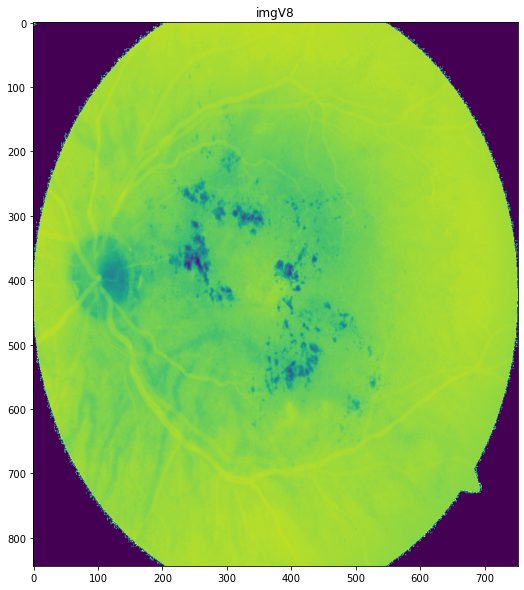

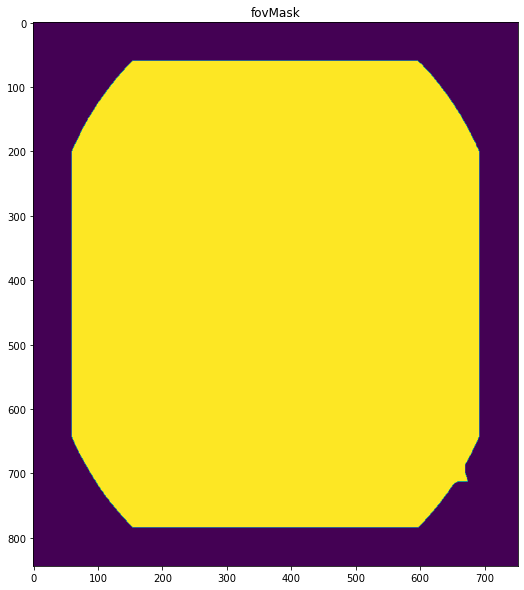

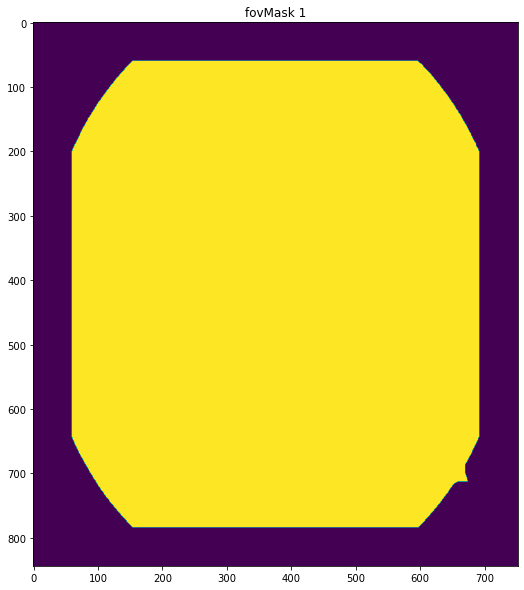

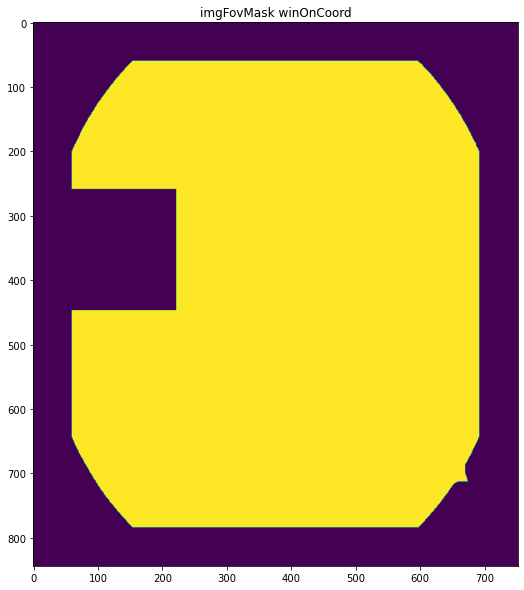

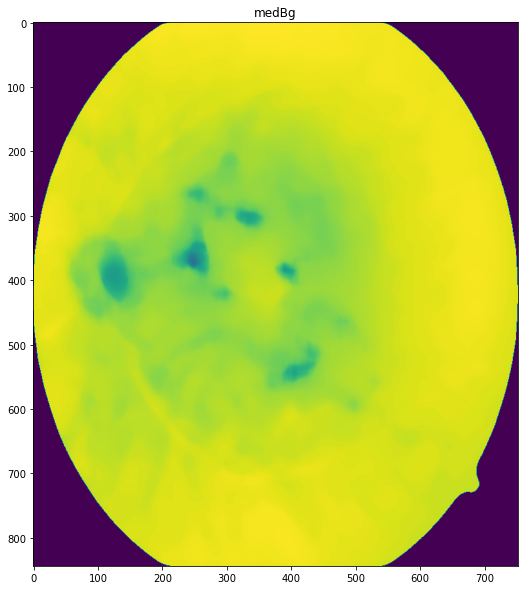

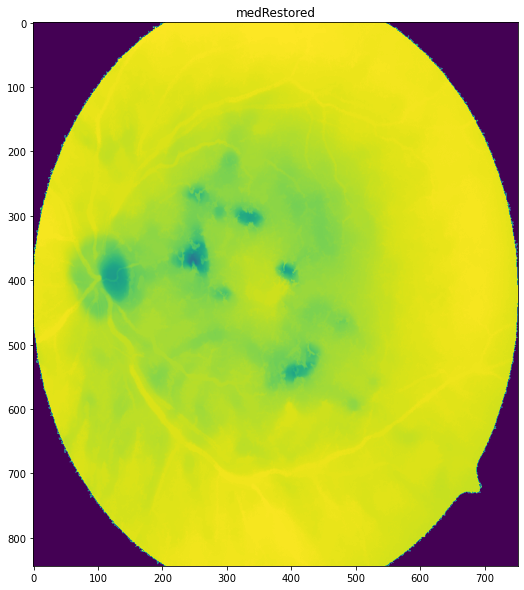

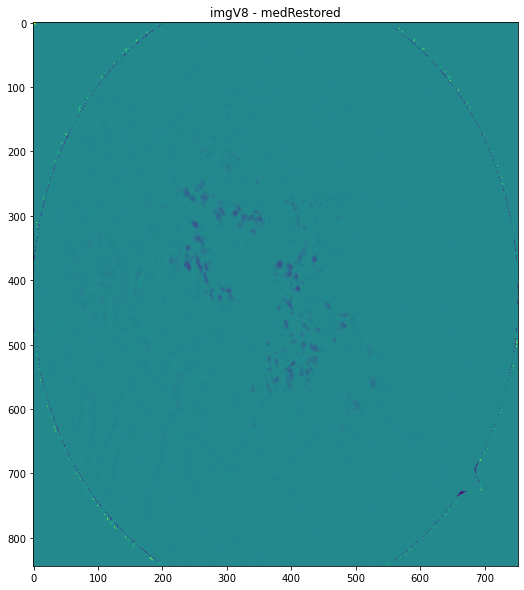

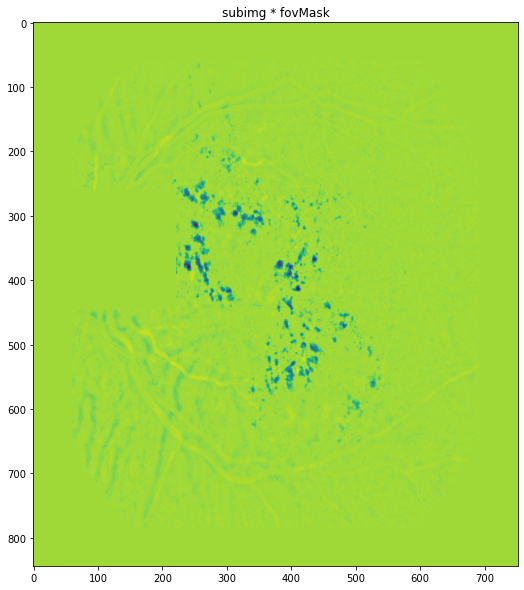

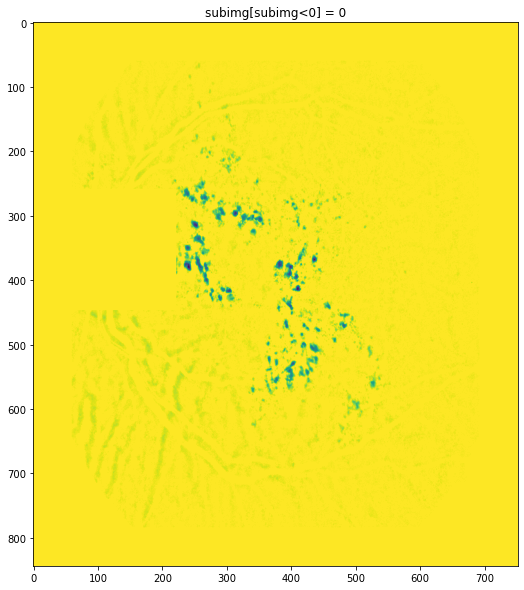

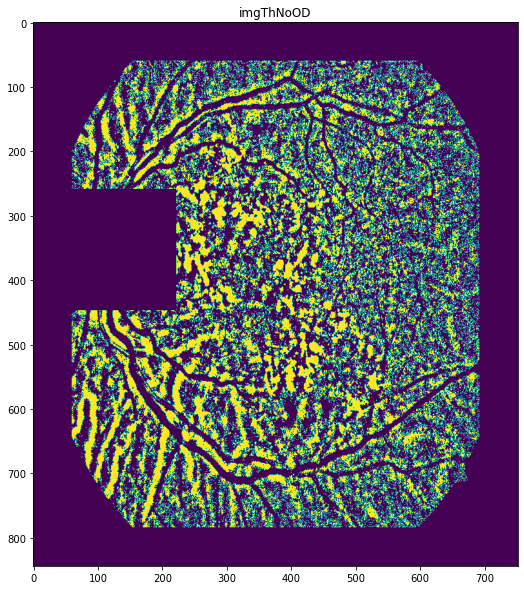

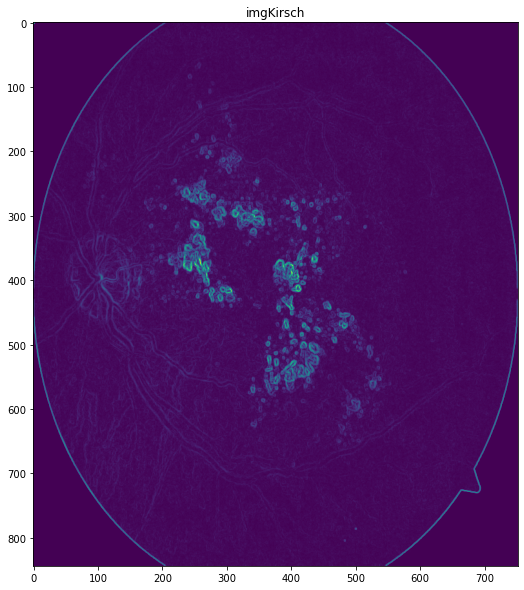

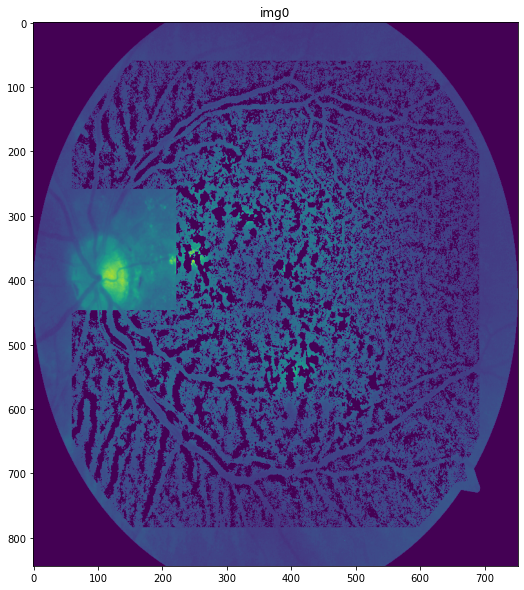

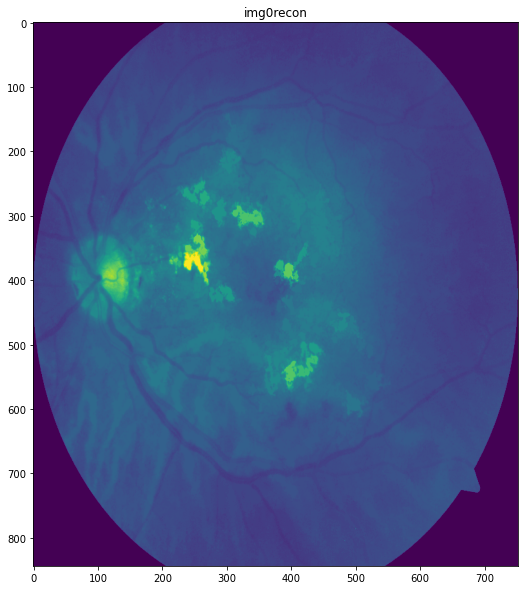

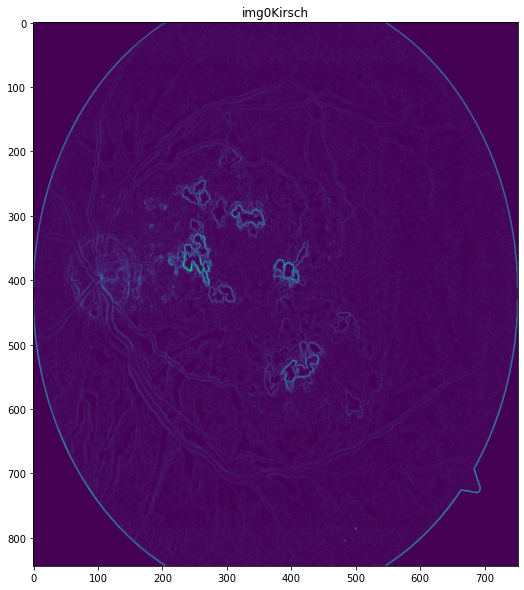

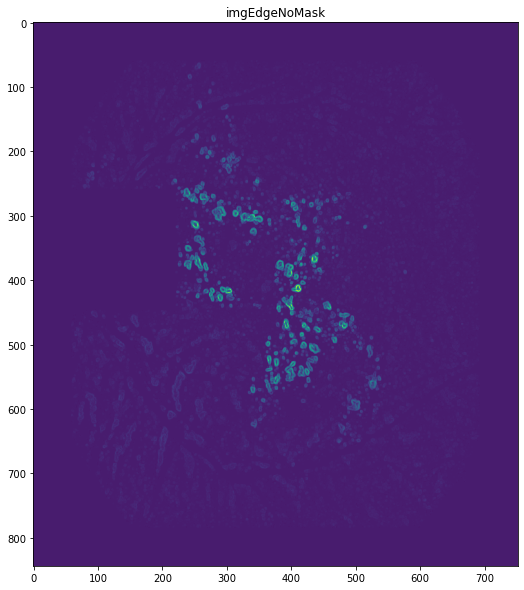

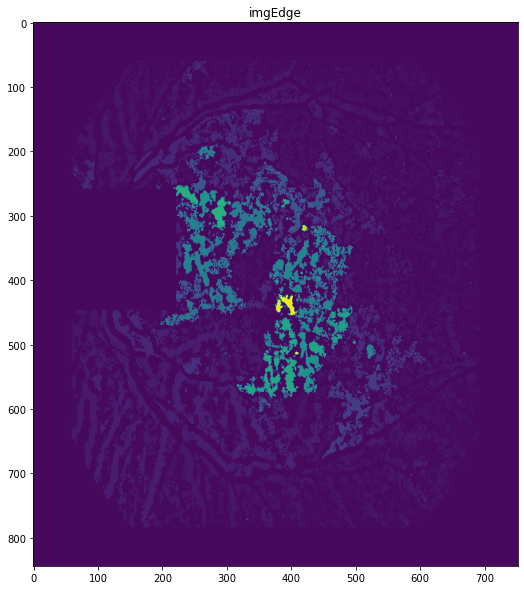

In [23]:
import pandas as pd
getLesions(x[0], 1, y[0][1], y[0][0])

In [ ]:
import re
def SearchingChallenge(str):
    str = str.lower()
    str = re.sub('[^a-zA-Z]', ' ', str)
    str = str.split()
    str = [word for word in str if len(word) > 1]
    str = sorted(str, key=lambda x: len(x), reverse=True)
    repeated = {}
    for word in str:
        for letter in range(len(word)):
            if word.count(word[letter]) > 1:
                repeated[f"{word}"] = word.count(word[letter])
    if not len(repeated.keys()):
        return -1
    else:
        return max(repeated, key=repeated.get)


print(SearchingChallenge("Today, is the greatest day ever!"))

In [ ]:
count = 0
while(True):
    if count % 3 ==0:
        print(count, end = " ")
    if count >= 15:
        break
    count +=1

In [ ]:
def replace_third_char(str_in):
  try:
    str_in += "xxxxxxxxxxxxxxxx"
  except:
    str_in = str(str_in)
    str_in += "xxxxxxxxxxxxxxx"

  str_out = ""
  str_out += str_in[0]
  for i in range(1, len(str_in)):
    if (i+1) % 3 == 0:
      str_out += "X"
    else:
      str_out += str_in[i]
  return str_out

In [ ]:
data = [10, 20, 50, 30, -10, 40, -20, -30, 0, 15]
import numpy as np
print(np.percentile(data, 20, axis=1))